# Práctica 1: Perceptrón multicapa.

Tu jefe pidió a RH que recolectara datos de desempeño de tus compañeros, los resultados se almacenaron en un csv. El punto critico de estos datos es la satisfacción del empleado, entonces ¿Podremos estimar la satisfacción de los empleados con los datos recabados?.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models


df = pd.read_csv('Extended_Employee_Performance_and_Productivity_Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Employee_ID                  100000 non-null  int64  
 1   Department                   100000 non-null  object 
 2   Gender                       100000 non-null  object 
 3   Age                          100000 non-null  int64  
 4   Job_Title                    100000 non-null  object 
 5   Hire_Date                    100000 non-null  object 
 6   Years_At_Company             100000 non-null  int64  
 7   Education_Level              100000 non-null  object 
 8   Performance_Score            100000 non-null  int64  
 9   Monthly_Salary               100000 non-null  float64
 10  Work_Hours_Per_Week          100000 non-null  int64  
 11  Projects_Handled             100000 non-null  int64  
 12  Overtime_Hours               100000 non-null  int64  
 13  

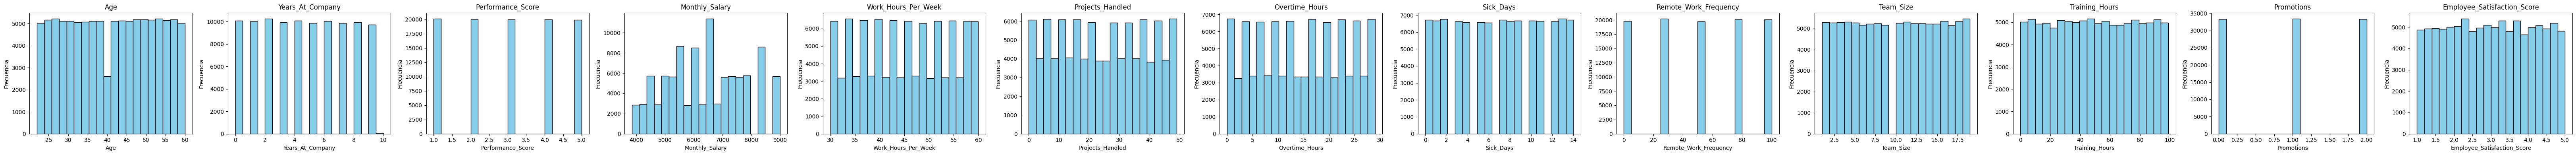

In [4]:
# Filtrar las columnas numéricas
numeric_columns = df.select_dtypes(include=['number']).drop('Employee_ID',axis=1)


# Si numeric_columns es un Index, conviértelo a lista
cols = list(numeric_columns)

fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 4))

for i, col in enumerate(cols):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Problemas**, tenemos distribuciones con picos, esos nos indica categorías. Por otro lado, tenemos variables con "valles" en su distribución (distribuciones multimodales) por lo que resultaría óptimo aplicar técnicas de feature engeneering. Por último tenemos distribuciones uniformes, por lo que cada una requeriría un procesamiento indivudual, hagamos la vista gorda e intentemos ajustar un MLP con estos datos, solo estandaricemos nuestros datos.

---

## Implementación de Red:

Tomemos los datos numéricos como nuestra variable X, y la variable objetivo como ***'Employee_Satisfaction_Score'***.
- **Actividad 1**: Para todos los strings ``'@modif@'`` que aparescan en el siguiente bloque de código cámbialos para que el código funcione.

In [7]:
# Línea 1 Corregida: Excluye la columna objetivo de X
# X debe ser todas las columnas numéricas MENOS la columna objetivo
columnas_X = [col for col in numeric_columns if col != 'Employee_Satisfaction_Score']
X = df[columnas_X]

# Línea 2 Corregida: Define Y como la columna objetivo
y = df['Employee_Satisfaction_Score']
y = y.apply(lambda x: round(x)-1) # Conversión de la variable objetivo

scaler = StandardScaler()
# El scaler funciona correctamente ahora porque X solo tiene números de entrada
X_estandar = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_estandar, y, test_size=0.33, random_state=42)

y_onehot_train = tf.keras.utils.to_categorical(y_train, 5)
y_onehot_test = tf.keras.utils.to_categorical(y_test, 5)

- **Actividad 2:** Implementa 3 arquitecturas de MLP, cada una con su propio nombre, cambiando la estructura de dichas arquitecturas (capas, neuronas por capa, función de activación, etc). 

In [8]:
# 1. Obtener la dimensión de entrada (número de características)
input_shape = X_estandar.shape[1] 
output_classes = 5

# --- Arquitectura 1: MLP Sencillo y Profundo (Baseline) ---
# Diseñado para ser un buen punto de partida con 4 capas, reduciendo el tamaño gradualmente.
def create_mlp_baseline(input_shape, output_classes):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)), # Capa 1: Entrada con 64 neuronas
        layers.Dense(32, activation='relu'),                              # Capa 2: 32 neuronas
        layers.Dense(16, activation='relu'),                              # Capa 3: 16 neuronas
        layers.Dense(output_classes, activation='softmax')                 # Capa de Salida: 5 clases
    ], name='MLP_Baseline')
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# --- Arquitectura 2: MLP Ancho con Regularización (Wide Network) ---
# Menos capas, pero más neuronas para capturar patrones más anchos rápidamente.
# Se añade regularización 'l2' para evitar sobreajuste.
def create_mlp_wide(input_shape, output_classes):
    model = models.Sequential([
        layers.Dense(128, activation='tanh', kernel_regularizer='l2', input_shape=(input_shape,)), # Capa 1: 128 neuronas, Tanh
        layers.Dropout(0.3),                                                                      # Regularización Dropout
        layers.Dense(64, activation='tanh'),                                                      # Capa 2: 64 neuronas, Tanh
        layers.Dense(output_classes, activation='softmax')                                        # Capa de Salida
    ], name='MLP_Wide_Regularized')
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# --- Arquitectura 3: MLP Muy Profundo y Delgado (Deep Network) ---
# Diseñado para ser más profundo con capas más delgadas, ideal para jerarquías de características.
def create_mlp_deep(input_shape, output_classes):
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(output_classes, activation='softmax')
    ], name='MLP_Deep_Thin')
    model.compile(optimizer='sgd', # Usamos otro optimizador
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# --- Creación y Resumen de Modelos ---

# 1. Crear instancias de los modelos
mlp_baseline = create_mlp_baseline(input_shape, output_classes)
mlp_wide = create_mlp_wide(input_shape, output_classes)
mlp_deep = create_mlp_deep(input_shape, output_classes)

# 2. Imprimir los resúmenes para ver las arquitecturas
print("--- Resumen de MLP_Baseline ---")
mlp_baseline.summary()
print("\n--- Resumen de MLP_Wide_Regularized ---")
mlp_wide.summary()
print("\n--- Resumen de MLP_Deep_Thin ---")
mlp_deep.summary()

--- Resumen de MLP_Baseline ---


c:\Users\aaron\OneDrive\1.- INGENIERIA EN SOFTWARE\6.- Cuatrimestre\Deep Learning\Perceptron multicapa\perceptr-n-multi-capa-Aaron-1990\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "MLP_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,525 (13.77 KB)

 Trainable params: 3,525 (13.77 KB)

 Non-trainable params: 0 (0.00 B)


--- Resumen de MLP_Wide_Regularized ---


Model: "MLP_Wide_Regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,245 (40.02 KB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 0 (0.00 B)


--- Resumen de MLP_Deep_Thin ---


Model: "MLP_Deep_Thin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453 (9.58 KB)

 Trainable params: 2,453 (9.58 KB)

 Non-trainable params: 0 (0.00 B)

- **Actividad 3:** Compila y ajusta tus tres modelos con sus respectivos hiperparámetros.

In [9]:
# Definición de hiperparámetros comunes para el entrenamiento
EPOCHS = 100
BATCH_SIZE = 32

# -----------------------------------------------------------
# 1. MLP Sencillo y Profundo (Baseline)
# -----------------------------------------------------------
print("--- Entrenando MLP_Baseline ---")

# El modelo ya está compilado con Adam por defecto en su función de creación.
history_baseline = mlp_baseline.fit(
    X_train, y_onehot_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_onehot_test),
    verbose=0 # Mantenemos 'verbose=0' para una salida limpia en el notebook
)

# -----------------------------------------------------------
# 2. MLP Ancho con Regularización (Wide Network)
# -----------------------------------------------------------
print("\n--- Entrenando MLP_Wide_Regularized (Adam) ---")

# Creamos un optimizador Adam con una tasa de aprendizaje (learning_rate) menor 
# para este modelo que tiene regularización L2.
opt_wide = tf.keras.optimizers.Adam(learning_rate=0.0005) 
mlp_wide.compile(optimizer=opt_wide, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

history_wide = mlp_wide.fit(
    X_train, y_onehot_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_onehot_test),
    verbose=0
)

# -----------------------------------------------------------
# 3. MLP Muy Profundo y Delgado (Deep Network)
# -----------------------------------------------------------
print("\n--- Entrenando MLP_Deep_Thin (SGD) ---")

# El modelo usa el optimizador SGD (Stochastic Gradient Descent) 
# y le añadiremos un momento para ayudar a la convergencia.
opt_deep = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
mlp_deep.compile(optimizer=opt_deep, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

history_deep = mlp_deep.fit(
    X_train, y_onehot_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_onehot_test),
    verbose=0
)

print("\n--- Entrenamiento Finalizado ---")
print(f"Modelo MLP_Baseline entrenado por {EPOCHS} épocas.")
print(f"Modelo MLP_Wide_Regularized entrenado por {EPOCHS} épocas.")
print(f"Modelo MLP_Deep_Thin entrenado por {EPOCHS} épocas.")

--- Entrenando MLP_Baseline ---

--- Entrenando MLP_Wide_Regularized (Adam) ---

--- Entrenando MLP_Deep_Thin (SGD) ---

--- Entrenamiento Finalizado ---
Modelo MLP_Baseline entrenado por 100 épocas.
Modelo MLP_Wide_Regularized entrenado por 100 épocas.
Modelo MLP_Deep_Thin entrenado por 100 épocas.


- **Actividad 4:** Sube tus cambios al repositorio, envía el link de tu repositorio a la actividad 2 de tu checkpoint 2 y contesta las preguntas de dicha actividad.